In [86]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

In [87]:
spot_init=100
int_rate=2/100
volatility=15/100
maturity=1
nb_step=12
time_step= maturity/nb_step
nb_path=20
nb_seed=20191008

In [88]:
drift_mod= (int_rate-0.5*volatility**2)*time_step
mat_drift= drift_mod*np.cumsum(np.ones((nb_path,nb_step)),axis=1)
volat_mod= volatility*np.sqrt(time_step)
np.random.seed(nb_seed)
mat_shock= np.random.standard_normal((nb_path,nb_step))
mat_shock_cum= np.cumsum(mat_shock,axis=1)
mat_volatility= volat_mod*mat_shock_cum
mat_log_spot= mat_drift+mat_volatility
mat_spot_init= spot_init*np.ones((nb_path,nb_step))
mat_spot_fut= mat_spot_init*np.exp(mat_log_spot)
vec_spot_init= spot_init*np.ones((nb_path,1))
mat_path_spot_fut= np.concatenate((vec_spot_init,np.round(mat_spot_fut,3)),axis=1)

In [89]:
mat_path_spot_fut;

In [90]:
def implied_malz_vol(spot,tt_maturity,strike,int_rate):
    alpha_1 = 0.58
    alpha_2 = -0.35
    #vol = volatility + (alpha_1/np.sqrt(tt_maturity))*np.log(spot*np.exp(int_rate*tt_maturity)/strike) + alpha_2*((1/np.sqrt(tt_maturity))*np.log(spot*np.exp(int_rate*tt_maturity)/strike))**2
    malz_vol = volatility + (alpha_1/np.sqrt(tt_maturity))*np.log(spot*np.exp(int_rate*tt_maturity)/strike) + alpha_2*((1/np.sqrt(tt_maturity))*np.log(spot*np.exp(int_rate*tt_maturity)/strike))**2
    return max(5/100,malz_vol)

In [110]:
def comp_price_call(mat_spot,strike,int_rate):
    mat_price_call = np.zeros((nb_path,nb_step+1))
    for i in range(nb_path):
        for j in range(nb_step+1):
            if j == 12:
                mat_price_call[i,j] = max(mat_spot[i,j] - strike,0)
            else:
                discount= np.exp(-int_rate*(nb_step-j)/nb_step)
                volatility = implied_malz_vol(mat_spot[i,j],(nb_step-j)/nb_step,strike,int_rate)
                volat_mod = volatility*np.sqrt((nb_step-j)/nb_step)
                moneyness= np.log(mat_spot[i,j]/strike)
                term_vol= (int_rate+0.5*volatility**2)*(nb_step-j)/nb_step
                d1=(moneyness+term_vol)/volat_mod
                d2=d1-volat_mod
                prob_d1=norm.cdf(d1)
                prob_d2=norm.cdf(d2)
                mat_price_call[i,j] = mat_spot[i,j]*prob_d1-discount*strike*prob_d2
    return mat_price_call 

def comp_delta_call(mat_spot,strike,int_rate):
    mat_delta_call = np.zeros((nb_path,nb_step))
    for i in range(nb_path):
        for j in range(nb_step):
            if j == 12 :
                if mat_spot[i,j] > strike :
                    mat_delta_call[i,j] = 1
                else :
                    mat_delta_call[i,j] = 0
            else : 
                volatility = implied_malz_vol(mat_spot[i,j],(nb_step-j)/nb_step,strike,int_rate)
                volat_mod= volatility*np.sqrt((nb_step-j)/nb_step)
                moneyness= np.log(mat_spot[i,j]/strike)
                term_vol= (int_rate+0.5*volatility**2)*(nb_step-j)/nb_step
                d1=(moneyness+term_vol)/volat_mod
                prob_d1=norm.cdf(d1)
                mat_delta_call[i,j] =prob_d1
    return mat_delta_call

## Question 1 & 3

In [111]:
mat_call_price = comp_price_call(mat_path_spot_fut,100,int_rate)
mat_call_delta = comp_delta_call(mat_path_spot_fut,100,int_rate)

In [115]:
mat_call_delta;

In [116]:
np.shape(mat_call_price)

(20, 13)

In [117]:
for i in range(nb_path):
    for j in range(nb_step+1):
        mat_call_price[i,j] = round(mat_call_price[i,j],2)
        mat_call_delta[i,j] = round(mat_call_delta[i,j],3)

IndexError: index 12 is out of bounds for axis 1 with size 12

In [118]:
mat_call_delta;

## Question 2

In [119]:
pnl_non_covered = np.zeros(nb_path)
nb_calls = 10000
for i in range(nb_path):
    if 100 < mat_path_spot_fut[i,-1]:
        pnl_non_covered[i] = round(nb_calls*mat_call_price[i,0]*(1-0.2/100) - nb_calls*(mat_path_spot_fut[i,-1] - 100) - nb_calls*mat_path_spot_fut[i,-1]*0.5/100 - nb_calls*100*0.5/100,2)
    else:
        pnl_non_covered[i] =  round(nb_calls*mat_call_price[i,0]*(1-0.2/100),2)

In [120]:
pnl_non_covered

array([  53298.8 ,   73945.8 , -146742.4 ,   73945.8 ,   73945.8 ,
         73945.8 , -105879.1 ,   60538.85,   73945.8 ,   73945.8 ,
         73945.8 ,   73945.8 ,   73945.8 ,   73945.8 ,   73945.8 ,
       -133677.4 ,  -75045.7 ,   41604.65,    7072.85, -198962.2 ])

## Question 4

In [121]:
stocks_to_hold = np.zeros((nb_path,nb_step))

for i in range(nb_path):
    for j in range(nb_step):
        '''if j == 0:
            stocks_to_hold[i,j] = mat_call_price[i,j]/(mat_call_delta[i,j]*mat_spot_fut[i,j])
        else:
            stocks_to_hold[i,j] = round((mat_call_price[i,j] - mat_call_price[i,j-1])/(mat_call_delta[i,j]*(mat_spot_fut[i,j]-mat_spot_fut[i,j-1])))'''
        stocks_to_hold[i,j] = round(nb_calls*mat_call_delta[i,j])

In [123]:
stocks_to_hold;

## Question 5

In [139]:
pnl_covered = np.zeros(nb_path)
nb_calls = 10000
for i in range(nb_path):
    borrowing_init = nb_calls*mat_call_price[i,0]*(1-0.2/100) - stocks_to_hold[i,0]*mat_path_spot_fut[i,0]*(1+0.5/100)
    borrowing = borrowing_init
    adjustments = stocks_to_hold[i,-1]*(mat_path_spot_fut[i,-1]-mat_path_spot_fut[i,nb_step-1])
    for j in range(1,nb_step):
        borrowing_bar = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + stocks_to_hold[i,j-1]*(mat_path_spot_fut[i,j] - mat_path_spot_fut[i,j-1])+ time_step*int_rate*borrowing_init
        borrowing_current = borrowing_bar + (stocks_to_hold[i,j-1]-stocks_to_hold[i,j])*mat_path_spot_fut[i,j]- abs(stocks_to_hold[i,j-1]-stocks_to_hold[i,j])*mat_path_spot_fut[i,j]*0.5/100
        borrowing += borrowing_current
        borrowing_init = borrowing_current
        adjustments += stocks_to_hold[i,j-1]*(mat_path_spot_fut[i,j]-mat_path_spot_fut[i,j-1])
    pnl_covered[i] =  round(nb_calls*(mat_call_price[i,0] - mat_call_price[i,-1]) + adjustments + time_step*int_rate*borrowing,2)
    if 100 < mat_path_spot_fut[i,-1]:
        pnl_covered[i] -= round(nb_calls*100*0.5/100 + (nb_calls-stocks_to_hold[i,-1])*mat_path_spot_fut[i,-1]*(1+0.5/100),2)
    else:
        pnl_covered[i] -= round(stocks_to_hold[i,-1]*mat_path_spot_fut[i,-1]*0.5/100,2)

In [140]:
pnl_covered

array([-164384.32,   14914.54,  -68955.18,   25844.28,    8588.11,
         17021.1 , -135721.28, -992357.54,  -11069.61,   27609.23,
         16288.98,   19950.9 ,   28066.12,   22859.89,   18895.39,
        -62754.67, -103592.07, -745431.02, -124017.84, -144125.24])

Text(0.5, 1.0, 'Covered and non covered strategies pnl')

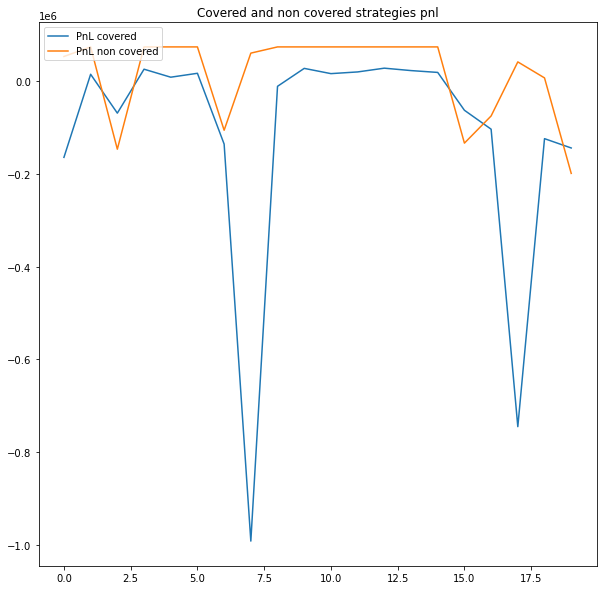

In [141]:
plt.figure(figsize=(10,10))
ax1 = plt.plot(pnl_covered,label="PnL covered")
ax2 = plt.plot(pnl_non_covered,label="PnL non covered")
plt.legend(loc="upper left")
plt.title("Covered and non covered strategies pnl")

## Question 6

In [202]:
nb_calls = 10000
stocks_to_hold_optim = np.zeros((nb_path,nb_step))
exp_call_zero = np.sum(mat_call_price[:,1])/20
exp_spot_zero = np.sum(mat_path_spot_fut[:,1])/20

for i in range(nb_path):
    borrowing_bar_vect = np.zeros((nb_step+1))
    
    for j in range(1,nb_step+1):
        borrowing_bar_candidates = np.zeros((nb_calls))
        borrowing_bar_toapp = np.zeros((nb_calls))
        borrowing_bar_candidates = [-np.inf for i in range(nb_calls)]
        proba = [np.exp(-1*abs(mat_path_spot_fut[l,j]-mat_path_spot_fut[i,j])) for l in range(nb_path)]
        proba /= np.sum(proba)
        exp_call = np.sum(mat_call_price[:,j]*proba)
        exp_spot = np.sum(mat_path_spot_fut[:,j]*proba)
        check = 0
        for trial in range(1,nb_calls):
            if exp_spot - mat_path_spot_fut[i,j-1] == 0:
                if j == 1 or j == nb_step:
                    check = 1
                    pass
                else:
                    if abs(borrowing_bar_vect[j-1] + (stocks_to_hold_optim[i,j-2] - trial)*mat_path_spot_fut[i,j-1] - abs(stocks_to_hold_optim[i,j-2] - trial)*mat_path_spot_fut[i,j-1]*0.5/100) <= mat_path_spot_fut[i,j-1]*stocks_to_hold_optim[i,j-2]*0.01 :
                        check = 1
                        pass
                    else:
                        continue
            else : 
                if j == 1 or j == nb_step:
                    check = 1
                    pass
                else:
                    if np.abs(time_step*int_rate*borrowing_bar_vect[j-1] - nb_calls*(exp_call-mat_call_price[i,j-1]) + trial*(exp_spot-mat_path_spot_fut[i,j-1])) <= nb_calls*mat_call_price[i,j-1]*0.01 :
                        check = 1
                        pass
                    else:
                        continue
            if j == 1:
                borrowing_bar_candidates[trial] = nb_calls*(mat_call_price[i,j-1]-exp_call_zero) + trial*(exp_spot_zero- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(nb_calls*mat_call_price[i,j-1]*(1-0.2/100)-trial*mat_path_spot_fut[i,j-1]*(1+0.5/100))
                borrowing_bar_toapp[trial] = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + trial*(mat_path_spot_fut[i,j]- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(nb_calls*mat_call_price[i,j-1]*(1-0.2/100)-trial*mat_path_spot_fut[i,j-1]*(1+0.5/100))

            elif j == nb_step:
                term1_exec = np.sum(trial*mat_path_spot_fut[:,j].T*proba*0.5/100 if mat_path_spot_fut[i,j] < 100 else 0)
                term2_exec = np.sum(nb_calls*100 + (nb_calls-trial)*trial*mat_path_spot_fut[:,j].T*proba if mat_path_spot_fut[i,j] < 100 else 0 )*(1+0.5/100)
                borrowing_bar_candidates[trial] = nb_calls*(mat_call_price[i,j-1]-exp_call) + trial*(exp_spot- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(borrowing_bar_vect[j-1]+(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]-abs(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]*0.5/100) - term1_exec - term2_exec
                if mat_path_spot_fut[i,j] < 100 : 
                    borrowing_bar_toapp[trial] = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + trial*(mat_path_spot_fut[i,j]- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(borrowing_bar_vect[j-1]+(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]-abs(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]*0.5/100) - trial*mat_path_spot_fut[i,j] - (nb_calls*100 + (nb_calls-trial)*mat_path_spot_fut[i,j]*(1+0.5/100))
                else :
                    borrowing_bar_toapp[trial] = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + trial*(mat_path_spot_fut[i,j]- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(borrowing_bar_vect[j-1]+(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]-abs(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]*0.5/100)

            else :
                borrowing_bar_candidates[trial] = nb_calls*(mat_call_price[i,j-1]-exp_call) + trial*(exp_spot- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(borrowing_bar_vect[j-1]+(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]-abs(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]*0.5/100)
                borrowing_bar_toapp[trial] = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + trial*(mat_path_spot_fut[i,j]- mat_path_spot_fut[i,j-1])+ time_step*int_rate*(borrowing_bar_vect[j-1]+(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]-abs(stocks_to_hold_optim[i,j-2]-trial)*mat_path_spot_fut[i,j-1]*0.5/100)
        if check == 1:
            if i == 0 and j == nb_step:
                print(borrowing_bar_candidates)
            stocks_to_hold_optim[i,j-1] = np.argmax(borrowing_bar_candidates)
        else:
            stocks_to_hold_optim[i,j-1] = 1
        borrowing_bar_vect[j] = borrowing_bar_toapp[np.argmax(borrowing_bar_candidates)]

[-inf, 68206.28879373276, 68200.13592617176, 68193.98305861079, 68187.83019104978, 68181.6773234888, 68175.5244559278, 68169.37158836682, 68163.21872080583, 68157.06585324483, 68150.91298568384, 68144.76011812287, 68138.60725056186, 68132.45438300088, 68126.30151543987, 68120.1486478789, 68113.99578031791, 68107.84291275691, 68101.69004519594, 68095.53717763493, 68089.38431007395, 68083.23144251296, 68077.07857495197, 68070.92570739098, 68064.77283982998, 68058.61997226899, 68052.467104708, 68046.31423714702, 68040.16136958603, 68034.00850202503, 68027.85563446405, 68021.70276690305, 68015.54989934206, 68009.39703178109, 68003.24416422009, 67997.0912966591, 67990.9384290981, 67984.78556153712, 67978.63269397613, 67972.47982641513, 67966.32695885414, 67960.17409129316, 67954.02122373217, 67947.86835617118, 67941.71548861019, 67935.5626210492, 67929.4097534882, 67923.25688592721, 67917.10401836624, 67910.95115080524, 67904.79828324425, 67898.64541568325, 67892.49254812227, 67886.33968056

In [199]:
stocks_to_hold_optim

array([[1.000e+00, 8.542e+03, 7.526e+03, 2.998e+03, 6.362e+03, 1.000e+00,
        7.595e+03, 8.731e+03, 8.280e+03, 9.794e+03, 1.000e+00, 1.000e+00],
       [1.000e+00, 9.822e+03, 8.362e+03, 4.176e+03, 3.650e+02, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 9.999e+03],
       [1.000e+00, 1.000e+00, 5.824e+03, 8.332e+03, 4.747e+03, 3.819e+03,
        5.457e+03, 6.964e+03, 8.118e+03, 8.653e+03, 8.930e+03, 1.000e+00],
       [1.000e+00, 5.892e+03, 1.000e+00, 6.233e+03, 1.000e+00, 8.691e+03,
        3.078e+03, 9.345e+03, 3.186e+03, 1.000e+00, 1.000e+00, 9.999e+03],
       [1.000e+00, 4.889e+03, 2.900e+02, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 9.999e+03],
       [1.000e+00, 1.000e+00, 7.928e+03, 9.915e+03, 2.416e+03, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 9.999e+03],
       [1.000e+00, 1.000e+00, 8.022e+03, 1.582e+03, 7.967e+03, 6.999e+03,
        5.828e+03, 8.712e+03, 1.

In [207]:
pnl_covered_optim = np.zeros(nb_path)
nb_calls = 10000
for i in range(nb_path):
    borrowing_init = nb_calls*mat_call_price[i,0]*(1-0.2/100) - stocks_to_hold_optim[i,0]*mat_path_spot_fut[i,0]*(1+0.5/100)
    borrowing = borrowing_init
    adjustments = stocks_to_hold_optim[i,-1]*(mat_path_spot_fut[i,-1]-mat_path_spot_fut[i,nb_step-1])
    for j in range(1,nb_step):
        borrowing_bar = nb_calls*(mat_call_price[i,j-1]-mat_call_price[i,j]) + stocks_to_hold_optim[i,j-1]*(mat_path_spot_fut[i,j] - mat_path_spot_fut[i,j-1])+ time_step*int_rate*borrowing_init
        borrowing_current = borrowing_bar + (stocks_to_hold_optim[i,j-1]-stocks_to_hold_optim[i,j])*mat_path_spot_fut[i,j]- abs(stocks_to_hold_optim[i,j-1]-stocks_to_hold_optim[i,j])*mat_path_spot_fut[i,j]*0.5/100
        borrowing += borrowing_current
        borrowing_init = borrowing_current
        adjustments += stocks_to_hold_optim[i,j-1]*(mat_path_spot_fut[i,j]-mat_path_spot_fut[i,j-1])
    pnl_covered_optim[i] =  round(nb_calls*(mat_call_price[i,0] - mat_call_price[i,-1]) + adjustments + time_step*int_rate*borrowing,2)
    if 100 < mat_path_spot_fut[i,-1]:
        pnl_covered_optim[i] -= round(nb_calls*100*0.5/100 + (nb_calls-stocks_to_hold_optim[i,-1])*mat_path_spot_fut[i,-1]*(1+0.5/100),2)
    else:
        pnl_covered_optim[i] -= round(stocks_to_hold_optim[i,-1]*mat_path_spot_fut[i,-1]*0.5/100,2)

Text(0.5, 1.0, 'Covered and non covered strategies pnl')

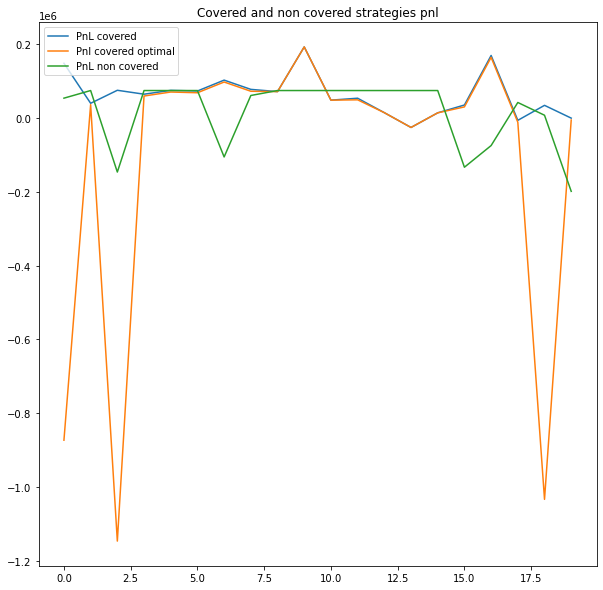

In [208]:
plt.figure(figsize=(10,10))
ax1 = plt.plot(pnl_covered,label="PnL covered")
ax2 = plt.plot(pnl_covered_optim,label="Pnl covered optimal")
ax3 = plt.plot(pnl_non_covered,label="PnL non covered")
plt.legend(loc="upper left")
plt.title("Covered and non covered strategies pnl")